# Notebook to generate data and plots for manuscript

In [23]:
import os,sys
import pandas as pd
from sklearn import manifold, datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, PCA
import numpy as np
import joblib as jl
import rdkit
from rdkit.Chem import (DataStructs)
import seaborn as sns
import matplotlib
import matplotlib as mpl
from matplotlib import colors
from matplotlib import ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.lines as mlines
import mpl_toolkits.mplot3d

ROOT_DIR = os.path.dirname(os.path.abspath('/scratch/work/sandsth2/SCRIPTS/MolAnalysis'))
sys.path.append('/scratch/work/sandsth2/Projects/atm_datasets_manuscript/') 
sys.path.append(ROOT_DIR)
sys.path.append('/scratch/work/sandsth2/Projects/atm_datasets_manuscript/src/fingerprint_comparison')
sys.path.append('/scratch/work/sandsth2/Projects/atm_datasets_manuscript/data/output/')

from src.visualization import plot_fun_groups as pfg
from MolAnalysis.descriptors import *
from MolAnalysis.loaddata import *
from MolAnalysis.compileanalysis import *

In [24]:
def load_datasets():
    """Load dataset locations. Update to filelist?"""
    datasets={'QM9':"qm9_data.dump",
              'Quinones':"tabor_nosulf.dump",
              'Wang':'wang_data.dump',
              'Gecko':'gecko_full.dump',
              'ExpMoNA':"allmona_cleaned.dump",
              'nablaDFT':"nablaDFT.dump",
             'mb_eu':"mb_eu_cleaned.dump"}
    return datasets

def load_atm_datasets():
    """Load dataset locations. Update to filelist?"""
    datasets={'Wang':'wang_data.dump',
              'Gecko':'gecko_full.dump',
              'Quinones':"tabor_nosulf.dump"}
    return datasets

def load_natm_datasets():
    """Load dataset locations. Update to filelist?"""
    datasets={'QM9':"qm9_data.dump",
              'nablaDFT':"nablaDFT.dump",
              'ExpMoNA':"allmona_cleaned.dump",
             'mb_eu':"mb_eu_cleaned.dump"}
    return datasets

def plot_number_of_heavy_atoms(dataframe, label, foldername):
    "Plot the distribution of the heavy atoms"
    # Set the palette
    colorblind_palette = ['#D55E00', '#E69F00', '#009E73', '#56B4E9', '#0072B2', '#CC79A7', '#F0E442']
    sns.set_palette(colorblind_palette)
    colors = colorblind_palette
    plt.rc('font', size=8)
    dataframe['# heavy atoms'] = dataframe['# heavy atoms'].astype('float32')
    fig, ax1 = plt.subplots(figsize=(2.38, 2.0), dpi=300, constrained_layout=True)
    sns.histplot(dataframe, x='# heavy atoms', ax=ax1, bins=25, discrete=True)
    plt.ylabel('Number of molecules')
    plt.xlabel('Number of heavy atoms')
    ax1.set_xticks(np.arange(0, np.max(dataframe['# heavy atoms'])+1,np.round(np.max(dataframe['# heavy atoms'])/10)))
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.tight_layout()
    plt.savefig(foldername+'/'+label+'_heavyAtoms_dist.png', bbox_inches='tight', dpi=320)
    plt.close()
    
def arange_heavy_atoms(dataframe, label):
    a_r = pd.concat([dataframe['# heavy atoms'].astype('float32').reset_index(drop=True), 
               pd.DataFrame(len(dataframe['# heavy atoms'])*[label]).rename({0:'label'}, axis='columns')], axis=1)
    return a_r

# Count number of molecules in the datasets

In [25]:
datasets = load_datasets()
for mol_key in datasets.keys():
    mol_set = jl.load('../data/processed/'+datasets[mol_key])
    print (mol_key + ": "+ str(len(mol_set)))

QM9: 133885
Quinones: 69599
Wang: 3414
Gecko: 166434
ExpMoNA: 681692
nablaDFT: 1004918
mb_eu: 21772


# List different atom species in dataset

In [26]:
datasets = load_datasets()
for key in datasets.keys():
    df = pd.read_csv('../data/output/'+key+'.descr.csv',  compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1}, low_memory=False)
    atoms_cols = [col for col in df.columns if 'Atoms' in col]
    # Get the values in a horizontal, comma-separated format
    values_str = ', '.join(map(str, df[atoms_cols].iloc[0].values))
    # Print key and values
    print(f"{key}: {values_str}")

QM9: O, C, H, N, F
Quinones: C, N, O, H, P
Wang: C, O, N, H, Cl, S, Br
Gecko: C, O, H, N
ExpMoNA: H, C, O, Cl, Si, I, S, N, Br, F, Na, P, Co, B, K, Fe, Ge, Sn, Cu, Mg, Pd, Al, Ni, Pt, Cr, Au, Se, Zn, Hg, As
nablaDFT: Br, C, N, H, O, S, Cl, F
mb_eu: C, O, H, Cl, Si, I, S, N, B, Br, F, P, As, Ge, Sn, Cu, Na, Pd, Al, Co, Ni, Pt, Se, Zn, Hg, K


# Plot t-SNE clusters

In [ ]:
def set_plot_settings(ax, xticks, yticks):
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Set the spines for the subplot
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)

def pandas_scatter_v2(data1, data2, title, ax1, ax2, s):
    plt.rc('font', size=8)
    mpl.rcParams['axes.linewidth'] = 0.1
    plt.rc('xtick', labelsize=8) 
    plt.rc('ytick', labelsize=8) 
    # Set the palette
    colorblind_palette = ['#D55E00', '#E69F00', '#009E73', '#56B4E9', '#0072B2', '#CC79A7', '#F0E442', '#000000']
    sns.set_palette(colorblind_palette)
    colors = colorblind_palette
    mycolors = []
    for c in np.arange(len(colors)): 
        mycolors.append(colors[c])

    # Scatter plot on the first subplot (ax1)
    sns.scatterplot(data=data1, x="x", y="y", hue="tag", ax=ax1, s=s, alpha=0.85, palette=mycolors)
    ticks = [-400, -200, 0, 200, 400]
    set_plot_settings(ax1, ticks,ticks)

    # Scatter plot on the second subplot (ax2)
    sns.scatterplot(data=data2, x="x", y="y", hue="tag", ax=ax2, s=s, alpha=0.85, palette=mycolors)
    set_plot_settings(ax2, ticks,ticks)

    # Create a legend for the second subplot (ax2)
    # Create legends for each subplot
    ax2.legend(['', 'QM9','nablaDFT','MONA', 'MassBank Europe', 'Gecko', 'Quinones', 'Wang'], loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 8}, fancybox=True)
  
    # Hide the legend for the first subplot (ax1)
    ax1.legend().set_visible(False)
    # Additional settings for the figure
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(title+'.png', dpi=340)

In [ ]:
data_v1 = pd.read_csv('/scratch/work/sandsth2/Projects/atm_datasets_manuscript/data/output/all-top_120124//Perplexity=50.csv', 
                   compression={'method': 'gzip', 'compresslevel': 1,'mtime': 1})
data_v2 = pd.read_csv('/scratch/work/sandsth2/Projects/atm_datasets_manuscript/data/output/all-maccs_120124/Perplexity=50.csv', 
                   compression={'method': 'gzip', 'compresslevel': 1,'mtime': 1})

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(504/72, (504/72)*(1.6/4)), sharey=True)
pandas_scatter_v2(data_v1, data_v2, "test_v2", ax1, ax2, 0.3)

## Tanimoto plot

In [ ]:
def plot_dataset_distr(datasets, keys, bin_edges, i, axs, colors, title):
    plt.rc('font', size=8)
    # Set the palette
    colorblind_palette = ['#D55E00', '#E69F00', '#009E73', '#56B4E9', '#0072B2', '#CC79A7', '#F0E442', '#000000']
    sns.set_palette(colorblind_palette)
    colors = colorblind_palette
    kwargs = dict(histtype='stepfilled', alpha=0.65, density=True, stacked=True, ec="k")
    for j in np.arange(len(keys)):
        total = pd.read_csv(datasets[keys[j]])
        if (i < 2): 
            ax = axs[0,i]
        elif (i > 1):
            i=i-2
            ax = axs[1,i]
            i=i+2
        ax.hist(bin_edges[:-1], bins=bin_edges, weights=total, color=colors[j], **kwargs)
        ax.legend(keys, fancybox=True, framealpha=0)
        
        # Set the spines to have a black color
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['left'].set_color('black')

        # Set the linewidth of the spines
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)

def plot_dataset_distr_outline(datasets, keys, bin_edges, i, axs, colors, title, legend):
    plt.rc('font', size=8)
    
    # Set the palette
    sns.set_palette(colorblind_palette)
    colors = colorblind_palette
    mapped_keys = keys.copy()
    
    if 'MassBank, Eu' in mapped_keys:
        mapped_keys[mapped_keys.index('MassBank, Eu')] = 'MassBank Eu'
        
    for j in np.arange(len(keys)):
        total = pd.read_csv(datasets[keys[j]])
        kwargs = dict(alpha=1, density=True, histtype='step',linewidth=1, edgecolor=colors[j])
        if (i < 2): 
            ax = axs[0,i]
        elif (i > 1):
            i=i-2
            ax = axs[1,i]
            i=i+2
            
        ax.hist(bin_edges[:-1], bins=bin_edges, weights=total,  **kwargs)
        # Create custom legend with colored lines
        legend_lines = [mlines.Line2D([], [], color=color, label=legend+'-'+key) for key, color in zip(mapped_keys, colors)]
        ax.legend(handles=legend_lines, fancybox=True, framealpha=0)
        
        # Set the spines to have a black color
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['left'].set_color('black')

        # Set the linewidth of the spines
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)        

## Tanimoto with vertical lines

In [7]:
def plot_dataset_distr(datasets, keys, bin_edges, i, axs, colors, title):
    plt.rc('font', size=8)
    
    # Set the palette
    colorblind_palette = ['#D55E00', '#E69F00', '#009E73', '#56B4E9', '#0072B2', '#CC79A7', '#F0E442', '#000000']
    sns.set_palette(colorblind_palette)
    colors = colorblind_palette
    kwargs = dict(histtype='stepfilled', alpha=0.65, density=True, stacked=True, ec="k")
    
    for j in np.arange(len(keys)):
        total = pd.read_csv(datasets[keys[j]])
        if (i < 2): 
            ax = axs[0,i]
        elif (i > 1):
            i=i-2
            ax = axs[1,i]
            i=i+2
        ax.hist(bin_edges[:-1], bins=bin_edges, weights=total, color=colors[j], **kwargs)
        ax.legend(keys, fancybox=True, framealpha=0)
        
        # Add vertical dashed lines
        ax.axvline(x=0.1, color='k', linestyle='--')
        ax.axvline(x=0.4, color='k', linestyle='--')
        
        # Set the spines to have a black color
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['left'].set_color('black')

        # Set the linewidth of the spines
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)
        
def plot_dataset_distr_outline(datasets, keys, bin_edges, i, axs, colors, title, legend):
    plt.rc('font', size=8)
    
    mapped_keys = keys.copy()
    
    if 'MassBank, Eu' in mapped_keys:
        mapped_keys[mapped_keys.index('MassBank, Eu')] = 'MassBank Eu'
        
    for j in np.arange(len(keys)):
        
        total = pd.read_csv(datasets[keys[j]])
        kwargs = dict(alpha=1, density=True, histtype='step',linewidth=1, edgecolor=colors[j])
        
        if (i < 2): 
            ax = axs[0,i]
        elif (i > 1):
            i=i-2
            ax = axs[1,i]
            i=i+2
            
        ax.hist(bin_edges[:-1], bins=bin_edges, weights=total,  **kwargs)
        # Create custom legend with colored lines
        legend_lines = [mlines.Line2D([], [], color=color, label=legend+'-'+key) for key, color in zip(mapped_keys, colors)]
        ax.legend(handles=legend_lines, fancybox=True, framealpha=0)
        
        # Add vertical dashed lines
        ax.axvline(x=0.1, color='k', linestyle='--', linewidth=1)
        ax.axvline(x=0.4, color='k', linestyle='--', linewidth=1)
        
        # Set the spines to have a black color
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['left'].set_color('black')

        # Set the linewidth of the spines
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)

In [27]:
datasets = load_datasets()
for key in datasets.keys():
    if key=='Wang':
        ref_bol=True
    else:
        ref_bol=False
    print(key)
    dir_maccs = '../data/output/'+key+'/bins_Wang_MACCS/'
    dir_top = '../data/output/'+key+'/bins_Wang_topological/'
    %run ../src/fingerprint_comparison/sum_bins.py -i {dir_maccs} -o {dir_maccs}  --ref {ref_bol}
    %run ../src/fingerprint_comparison/sum_bins.py -i {dir_top} -o {dir_top}  --ref {ref_bol}

QM9
Analyzing subtotal #0
Analyzing subtotal #1
Analyzing subtotal #2
Analyzing subtotal #3
Analyzing subtotal #4
Analyzing subtotal #5
Analyzing subtotal #6
Analyzing subtotal #7
Analyzing subtotal #8
Analyzing subtotal #9
Analyzing subtotal #10
Analyzing subtotal #11
Analyzing subtotal #12
Analyzing subtotal #13
Analyzing subtotal #14
Analyzing subtotal #15
Analyzing subtotal #16
Analyzing subtotal #17
Analyzing subtotal #18
Analyzing subtotal #19
Analyzing subtotal #20
Analyzing subtotal #21
Analyzing subtotal #22
Analyzing subtotal #0
Analyzing subtotal #1
Analyzing subtotal #2
Analyzing subtotal #3
Analyzing subtotal #4
Analyzing subtotal #5
Analyzing subtotal #6
Analyzing subtotal #7
Analyzing subtotal #8
Analyzing subtotal #9
Analyzing subtotal #10
Analyzing subtotal #11
Analyzing subtotal #12
Analyzing subtotal #13
Analyzing subtotal #14
Analyzing subtotal #15
Analyzing subtotal #16
Analyzing subtotal #17
Analyzing subtotal #18
Analyzing subtotal #19
Analyzing subtotal #20
Anal

In [28]:
cm = 1/2.54
maccs_atm_datasets_wang={'Wang':"../data/output/Wang/bins_Wang_MACCS/sum_total.csv",
                         'Gecko':'../data/output/Gecko/bins_Wang_MACCS/sum_total.csv',
          'Quinones':"../data/output/Quinones/bins_Wang_MACCS/sum_total.csv"}
topo_atm_datasets_wang={'Wang':"../data/output/Wang/bins_Wang_topological/sum_total.csv",
                        'Gecko':'../data/output/Gecko/bins_Wang_topological/sum_total.csv',
          'Quinones':"../data/output/Quinones/bins_Wang_topological/sum_total.csv"}
maccs_natm_datasets_wang={'Wang':"../data/output/Wang/bins_Wang_MACCS/sum_total.csv",
                          'MONA':'../data/output/ExpMoNA/bins_Wang_MACCS/sum_total.csv',
          'MassBank, Eu':'../data/output/mb_eu/bins_Wang_MACCS/sum_total.csv',
          'QM9':'../data/output/QM9/bins_Wang_MACCS/sum_total.csv',
          'nablaDFT':"../data/output/nablaDFT/bins_Wang_MACCS/sum_total.csv"}
topo_natm_datasets_wang={'Wang':"../data/output/Wang/bins_Wang_topological/sum_total.csv",
                         'MONA':'../data/output/ExpMoNA/bins_Wang_topological/sum_total.csv',
          'MassBank, Eu':'../data/output/mb_eu/bins_Wang_topological/sum_total.csv',
                         'QM9':'../data/output/QM9/bins_Wang_topological/sum_total.csv',
          'nablaDFT':"../data/output/nablaDFT/bins_Wang_topological/sum_total.csv"}

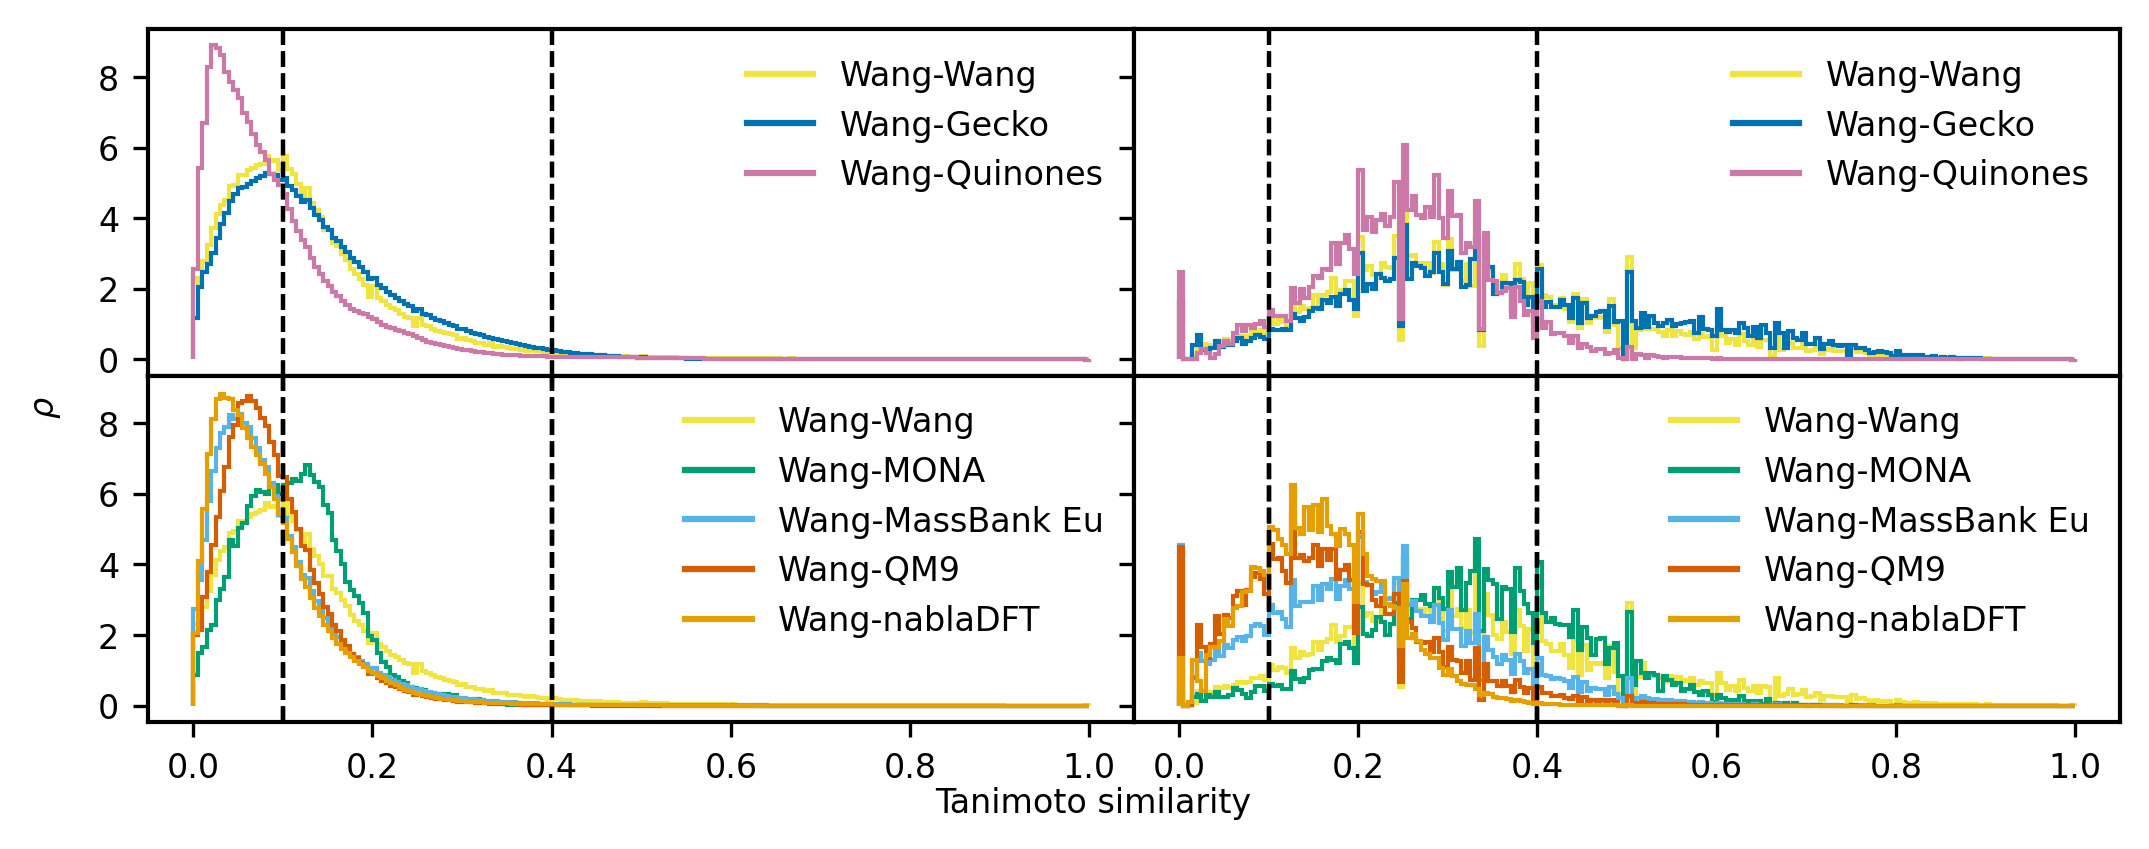

In [29]:
cm = 1/2.54
nbins = 200
bin_edges = np.linspace(0, 1, nbins + 1)
total = np.zeros(nbins)

# Set the palette
sns.set_palette(colorblind_palette)
colors = colorblind_palette
legend='Wang'

color_atm = [colors[6], colors[4], colors[5]]
color_natm = [colors[6],   colors[2],  colors[3], colors[0], colors[1]]

fig, axs = plt.subplots(2,2, sharey=True, sharex=True, figsize=(18.0*cm,7.0*cm), dpi=300, gridspec_kw = {'wspace':0, 'hspace':0})
plot_dataset_distr_outline(maccs_atm_datasets_wang, list(maccs_atm_datasets_wang.keys()), bin_edges,
                   1, axs, color_atm, '../reports/figures/atm_maccs_150124', legend)
plot_dataset_distr_outline(maccs_natm_datasets_wang, list(maccs_natm_datasets_wang.keys()),bin_edges,
                   3, axs, color_natm, '../reports/figures/natm_maccs_150124', legend)
plot_dataset_distr_outline(topo_atm_datasets_wang, list(topo_atm_datasets_wang.keys()), bin_edges,
                   0, axs, color_atm, '../reports/figures/atm_topo_150124', legend)
plot_dataset_distr_outline(topo_natm_datasets_wang, list(topo_natm_datasets_wang.keys()), bin_edges,
                   2, axs, color_natm, '../reports/figures/natm_topo_wang_150124', legend)

fig.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.01, 'Tanimoto similarity', ha='center')
fig.text(0.0, 0.5, r"$\rho$", va='center', rotation='vertical')

plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.tight_layout() 
plt.savefig('../reports/figures/all_tanimoto_wang_outline_120324'+'.png',  dpi=300, transparent=True)

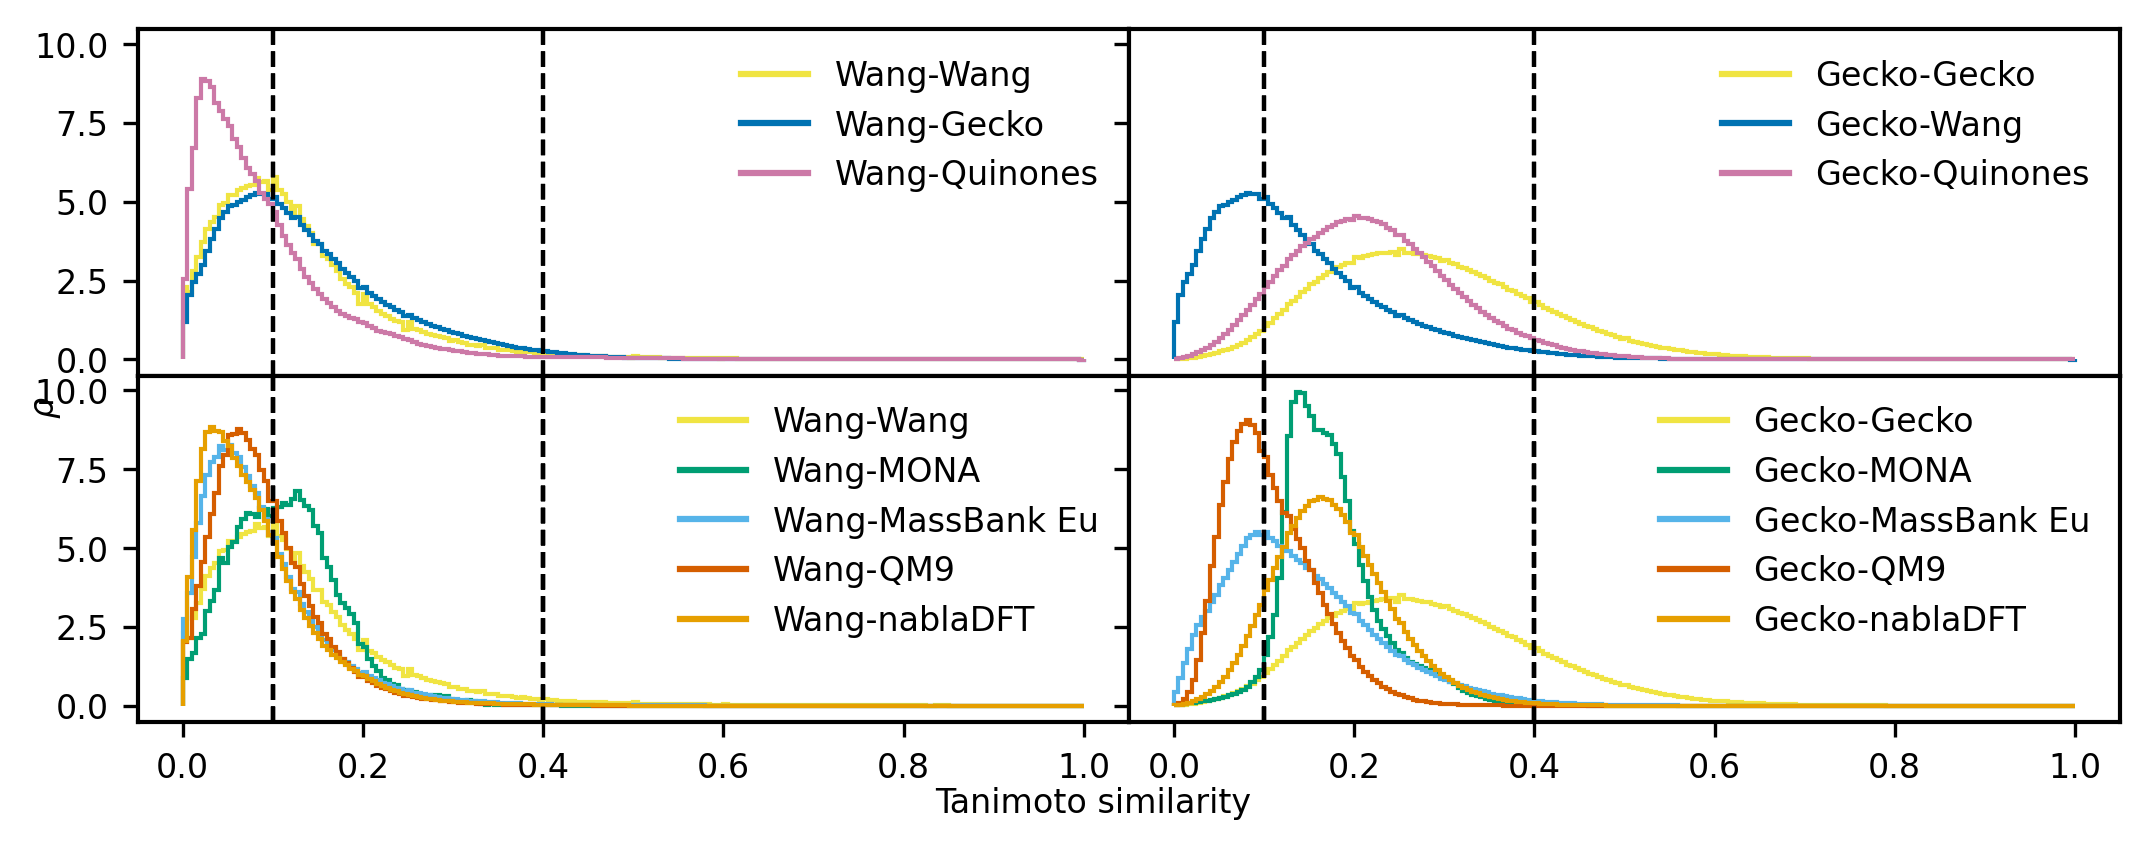

In [30]:
nbins = 200
bin_edges = np.linspace(0, 1, nbins + 1)
total = np.zeros(nbins)

# Define the color palette
colorblind_palette = ['#D55E00', '#E69F00', '#009E73', '#56B4E9', '#0072B2', '#CC79A7', '#F0E442']

# Set the palette
sns.set_palette(colorblind_palette)
colors = colorblind_palette

color_atm = [colors[6], colors[4], colors[5]]
color_natm = [colors[6],   colors[2],  colors[3], colors[0], colors[1]]


legend='Gecko'
fig, axs = plt.subplots(2,2, sharey=True, sharex=True, figsize=(18.0*cm,7.0*cm), dpi=300, gridspec_kw = {'wspace':0, 'hspace':0})
plot_dataset_distr_outline(topo_atm_datasets_gecko, list(maccs_atm_datasets_gecko.keys()), bin_edges,
                   1, axs, color_atm, '../reports/figures/atm_maccs_150124', legend)
plot_dataset_distr_outline(topo_natm_datasets_gecko, list(maccs_natm_datasets_gecko.keys()),bin_edges,
                   3, axs, color_natm, '../reports/figures/natm_maccs_150124', legend)
legend='Wang'
plot_dataset_distr_outline(topo_atm_datasets_wang, list(topo_atm_datasets_wang.keys()), bin_edges,
                   0, axs, color_atm, '../reports/figures/atm_topo_150124', legend)
plot_dataset_distr_outline(topo_natm_datasets_wang, list(topo_natm_datasets_wang.keys()), bin_edges,
                   2, axs, color_natm, '../reports/figures/natm_topo_wang_150124', legend)
fig.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.01, 'Tanimoto similarity', ha='center')
fig.text(0.0, 0.5, r"$\rho$", va='center', rotation='vertical')

plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.tight_layout() 
plt.savefig('../reports/figures/all_tanimoto_top_outline_120324'+'.png',  dpi=300, transparent=True)

In [ ]:
nbins = 200
bin_edges = np.linspace(0, 1, nbins + 1)
total = np.zeros(nbins)

# Define the color palette
colorblind_palette = ['#D55E00', '#E69F00', '#009E73', '#56B4E9', '#0072B2', '#CC79A7', '#F0E442']

# Set the palette
sns.set_palette(colorblind_palette)
colors = colorblind_palette

color_atm = [colors[6], colors[4], colors[5]]
color_natm = [colors[6],   colors[2],  colors[3], colors[0], colors[1]]

legend='Gecko'
fig, axs = plt.subplots(2,2, sharey=True, sharex=True, figsize=(18.0*cm,7.0*cm), dpi=300, gridspec_kw = {'wspace':0, 'hspace':0})
plot_dataset_distr_outline(maccs_atm_datasets_gecko, list(maccs_atm_datasets_gecko.keys()), bin_edges,
                   1, axs, color_atm, '../reports/figures/atm_maccs_150124', legend)
plot_dataset_distr_outline(maccs_natm_datasets_gecko, list(maccs_natm_datasets_gecko.keys()),bin_edges,
                   3, axs, color_natm, '../reports/figures/natm_maccs_150124', legend)
legend='Wang'
plot_dataset_distr_outline(maccs_atm_datasets_wang, list(maccs_atm_datasets_wang.keys()), bin_edges,
                   0, axs, color_atm, '../reports/figures/atm_topo_150124', legend)
plot_dataset_distr_outline(maccs_natm_datasets_wang, list(maccs_natm_datasets_wang.keys()), bin_edges,
                   2, axs, color_natm, '../reports/figures/natm_topo_wang_150124', legend)
fig.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.01, 'Tanimoto similarity', ha='center')
fig.text(0.0, 0.5, r"$\rho$", va='center', rotation='vertical')

plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.tight_layout() 
plt.savefig('../reports/figures/all_tanimoto_maccs_outline_120324'+'.png',  dpi=300, transparent=True)

In [ ]:
datasets = load_datasets()
for key in datasets.keys():
    if key=='Gecko':
        ref_bol=True
    else:
        ref_bol=False
    print(key)
    dir_maccs = '../data/output/'+key+'/bins_Gecko_MACCS/'
    dir_top = '../data/output/'+key+'/bins_Gecko_topological/'
    %run ../src/fingerprint_comparison/sum_bins.py -i {dir_maccs} -o {dir_maccs}  --ref {ref_bol}
    %run ../src/fingerprint_comparison/sum_bins.py -i {dir_top} -o {dir_top}  --ref {ref_bol}

In [12]:
cm = 1/2.54
maccs_atm_datasets_gecko={'Gecko':'../data/output/Gecko/bins_Gecko_MACCS/sum_total.csv',
                          'Wang':"../data/output/Wang/bins_Gecko_MACCS/sum_total.csv",
          'Quinones':"../data/output/Quinones/bins_Gecko_MACCS/sum_total.csv"}
topo_atm_datasets_gecko={'Gecko':'../data/output/Gecko/bins_Gecko_topological/sum_total.csv',
                         'Wang':"../data/output/Wang/bins_Gecko_topological/sum_total.csv",
          'Quinones':"../data/output/Quinones/bins_Gecko_topological/sum_total.csv"}
maccs_natm_datasets_gecko={'Gecko':'../data/output/Gecko/bins_Gecko_MACCS/sum_total.csv',
                          'MONA':'../data/output/ExpMoNA/bins_Gecko_MACCS/sum_total.csv',
          'MassBank, Eu':'../data/output/mb_eu/bins_Gecko_MACCS/sum_total.csv',
          'QM9':'../data/output/QM9/bins_Gecko_MACCS/sum_total.csv',
          'nablaDFT':"../data/output/nablaDFT/bins_Gecko_MACCS/sum_total.csv"}
topo_natm_datasets_gecko={'Gecko':'../data/output/Gecko/bins_Gecko_topological/sum_total.csv',
                         'MONA':'../data/output/ExpMoNA/bins_Gecko_topological/sum_total.csv',
          'MassBank, Eu':'../data/output/mb_eu/bins_Gecko_topological/sum_total.csv',
                         'QM9':'../data/output/QM9/bins_Gecko_topological/sum_total.csv',
          'nablaDFT':"../data/output/nablaDFT/bins_Gecko_topological/sum_total.csv"}

In [ ]:
nbins = 200
bin_edges = np.linspace(0, 1, nbins + 1)
total = np.zeros(nbins)
# Define the color palette
colorblind_palette = ['#D55E00', '#E69F00', '#009E73', '#56B4E9', '#0072B2', '#CC79A7', '#F0E442']

# Set the palette
sns.set_palette(colorblind_palette)
colors = colorblind_palette

color_atm = [colors[6], colors[4], colors[5]]
color_natm = [colors[6],   colors[2],  colors[3], colors[0], colors[1]]

fig, axs = plt.subplots(2,2, sharey=True, sharex=True, figsize=(18.0*cm,7.0*cm), dpi=300, gridspec_kw = {'wspace':0, 'hspace':0})
plot_dataset_distr(maccs_atm_datasets_gecko, list(maccs_atm_datasets_gecko.keys()), bin_edges,
                   1, axs, color_atm, '../reports/figures/atm_maccs_150124')
plot_dataset_distr(maccs_natm_datasets_gecko, list(maccs_natm_datasets_gecko.keys()), bin_edges,
                   3, axs, color_natm, '../reports/figures/natm_maccs_150124')
plot_dataset_distr(topo_atm_datasets_gecko, list(topo_atm_datasets_gecko.keys()), bin_edges,
                   0, axs, color_atm, '../reports/figures/atm_topo_150124')
plot_dataset_distr(topo_natm_datasets_gecko, list(topo_natm_datasets_gecko.keys()), bin_edges,
                   2, axs, color_natm, '../reports/figures/natm_topo_wang_150124')
fig.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.01, 'Tanimoto similarity', ha='center')
fig.text(0.0, 0.5, r"$\rho$", va='center', rotation='vertical')
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.tight_layout() 
plt.savefig('../reports/figures/all_tanimoto_gecko_220124'+'.png',  dpi=300, transparent=True)

In [ ]:
nbins = 200
bin_edges = np.linspace(0, 1, nbins + 1)
total = np.zeros(nbins)

# Set the palette
colorblind_palette = ['#D55E00', '#E69F00', '#009E73', '#56B4E9', '#0072B2', '#CC79A7', '#F0E442']
sns.set_palette(colorblind_palette)
colors = colorblind_palette

color_atm = [colors[6], colors[4], colors[5]]
color_natm = [colors[6],   colors[2],  colors[3], colors[0], colors[1]]
legend='Gecko'
fig, axs = plt.subplots(2,2, sharey=True, sharex=True, figsize=(18.0*cm,7.0*cm), dpi=300, gridspec_kw = {'wspace':0, 'hspace':0})
plot_dataset_distr_outline(maccs_atm_datasets_gecko, list(maccs_atm_datasets_gecko.keys()), bin_edges,
                   1, axs, color_atm, '../reports/figures/atm_maccs_150124',legend)
plot_dataset_distr_outline(maccs_natm_datasets_gecko, list(maccs_natm_datasets_gecko.keys()), bin_edges,
                   3, axs, color_natm, '../reports/figures/natm_maccs_150124',legend)
plot_dataset_distr_outline(topo_atm_datasets_gecko, list(topo_atm_datasets_gecko.keys()), bin_edges,
                   0, axs, color_atm, '../reports/figures/atm_topo_150124',legend)
plot_dataset_distr_outline(topo_natm_datasets_gecko, list(topo_natm_datasets_gecko.keys()), bin_edges,
                   2, axs, color_natm, '../reports/figures/natm_topo_wang_150124', legend)
fig.subplots_adjust(wspace=0, hspace=0)
fig.text(0.5, 0.01, 'Tanimoto similarity', ha='center')
fig.text(0.0, 0.5, r"$\rho$", va='center', rotation='vertical')
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.tight_layout() 
plt.savefig('../reports/figures/all_tanimoto_gecko_outline_220124'+'.png',  dpi=300, transparent=True)

## SI plot

In [16]:
maccs_5 = pd.read_csv('/scratch/work/sandsth2/Projects/atm_datasets_manuscript/data/output/all-maccs_120124/Perplexity=5.csv', 
                   compression={'method': 'gzip', 'compresslevel': 1,'mtime': 1})
maccs_50 = pd.read_csv('/scratch/work/sandsth2/Projects/atm_datasets_manuscript/data/output/all-maccs_120124/Perplexity=50.csv', 
                   compression={'method': 'gzip', 'compresslevel': 1,'mtime': 1})
maccs_100 = pd.read_csv('/scratch/work/sandsth2/Projects/atm_datasets_manuscript/data/output/all-maccs_120124/Perplexity=100.csv', 
                   compression={'method': 'gzip', 'compresslevel': 1,'mtime': 1})

In [17]:
top_5 = pd.read_csv('/scratch/work/sandsth2/Projects/atm_datasets_manuscript/data/output/all-top_120124/Perplexity=5.csv', 
                   compression={'method': 'gzip', 'compresslevel': 1,'mtime': 1})
top_50 = pd.read_csv('/scratch/work/sandsth2/Projects/atm_datasets_manuscript/data/output/all-top_120124/Perplexity=50.csv', 
                   compression={'method': 'gzip', 'compresslevel': 1,'mtime': 1})
top_100 = pd.read_csv('/scratch/work/sandsth2/Projects/atm_datasets_manuscript/data/output/all-top_120124/Perplexity=100.csv', 
                   compression={'method': 'gzip', 'compresslevel': 1,'mtime': 1})

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

def set_plot_settings(ax, xticks, yticks):
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Set the spines for the subplot
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    
def pandas_scatter_v3(data1, data2, data3, title, ax1, ax2, ax3, ax4, s):
    plt.rc('font', size=8)
    mpl.rcParams['axes.linewidth'] = 0.1
    plt.rc('xtick', labelsize=8)
    plt.rc('ytick', labelsize=8) 
    colorblind_palette = ['#D55E00', '#E69F00', '#009E73', '#56B4E9', '#0072B2', '#CC79A7', '#F0E442']
    sns.set_palette(colorblind_palette)
    mycolors = colorblind_palette


    # Scatter plot on the first subplot (ax1)
    sns.scatterplot(data=data1, x="x", y="y", hue="tag", ax=ax1, s=s, alpha=0.85, palette=mycolors)
    ticks = [-400, -200, 0, 200, 400]
    set_plot_settings(ax1, ticks, ticks)

    # Scatter plot on the second subplot (ax2)
    sns.scatterplot(data=data2, x="x", y="y", hue="tag", ax=ax2, s=s, alpha=0.85, palette=mycolors)
    set_plot_settings(ax2, ticks, ticks)

    # Scatter plot on the third subplot (ax3)
    sns.scatterplot(data=data3, x="x", y="y", hue="tag", ax=ax3, s=s, alpha=0.85, palette=mycolors)
    set_plot_settings(ax3, ticks, ticks)
    ax4.axis('off')
    # Create a legend outside the plot for the second row
    # ax3.legend(['', 'QM9','nablaDFT','MONA', 'MassBank,Europe', 'Gecko', 'Quinones', 'Wang'],loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 8}, fancybox=True)

    # Create a legend for the third subplot (ax3)
    # Create legends for each subplot
    # Hide the legends for the first two subplots (ax1 and ax2)
    ax1.legend().set_visible(False)
    ax2.legend().set_visible(False)
    ax3.legend().set_visible(False)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
    # Additional settings for the figure
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(title+'.png', dpi=340)

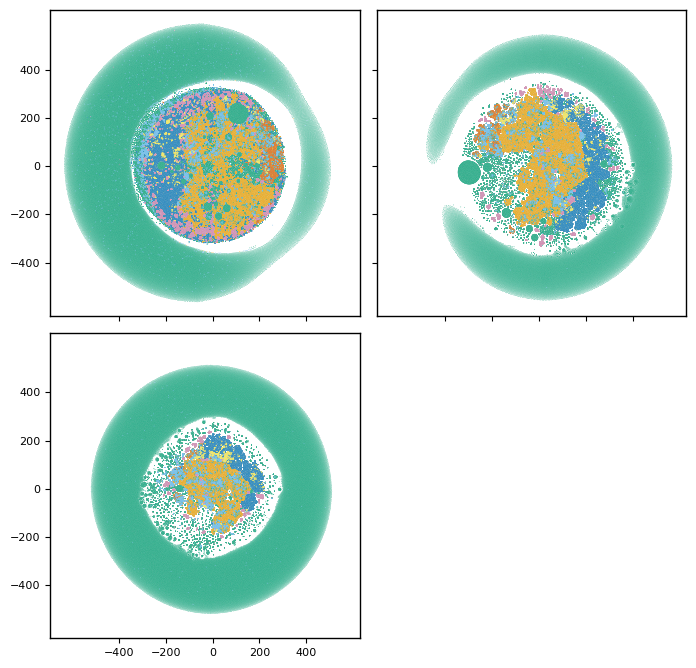

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(504/72, 1*(504/72)), sharex=True,  sharey=True)
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]
pandas_scatter_v3(top_5, top_50, top_100, "top_all_perplexities", ax1, ax2, ax3, ax4, 0.3)

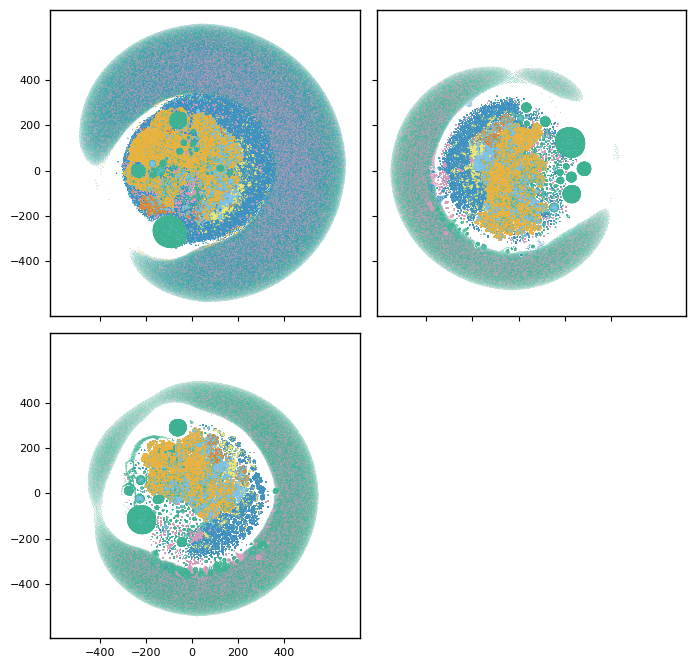

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(504/72, 1*(504/72)), sharex=True,  sharey=True)
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]
pandas_scatter_v3(maccs_5, maccs_50, maccs_100, "maccs_all_perplexities", ax1, ax2, ax3, ax4, 0.3)

# Plot property distributions

In [21]:
foldername = '../reports/figures/'
output_filepath = '../data/output/'

In [37]:
datasets = load_atm_datasets()
ar_list = []
adist_list = []
for label in datasets.keys(): 
    d=pd.read_csv(output_filepath+label+'.descr.csv', 
                  compression={'method':'gzip', 'compresslevel': 1,'mtime': 1}, 
                  low_memory=False)
    orig = d.copy(deep=True)
    a_types = arange_atomic_distribution(d).reset_index().rename({0:'number'}, axis='columns')
    d.columns = d.iloc[0]
    d.drop(0, inplace=True)
    a_r = arange_atomic_ratios(d, label)
    ar_list.append(a_r)  
    adist_list.append(arange_heavy_atoms(d, label))
    plot_number_of_heavy_atoms(d, label, foldername)
    
ar_pd = pd.concat(ar_list, axis=0)    
adist_pd = pd.concat(adist_list, axis=0)  

Sum of normalized counts for 'Quinones': 1.0
Sum of normalized counts for 'Gecko': 1.0
Sum of normalized counts for 'Wang': 1.0


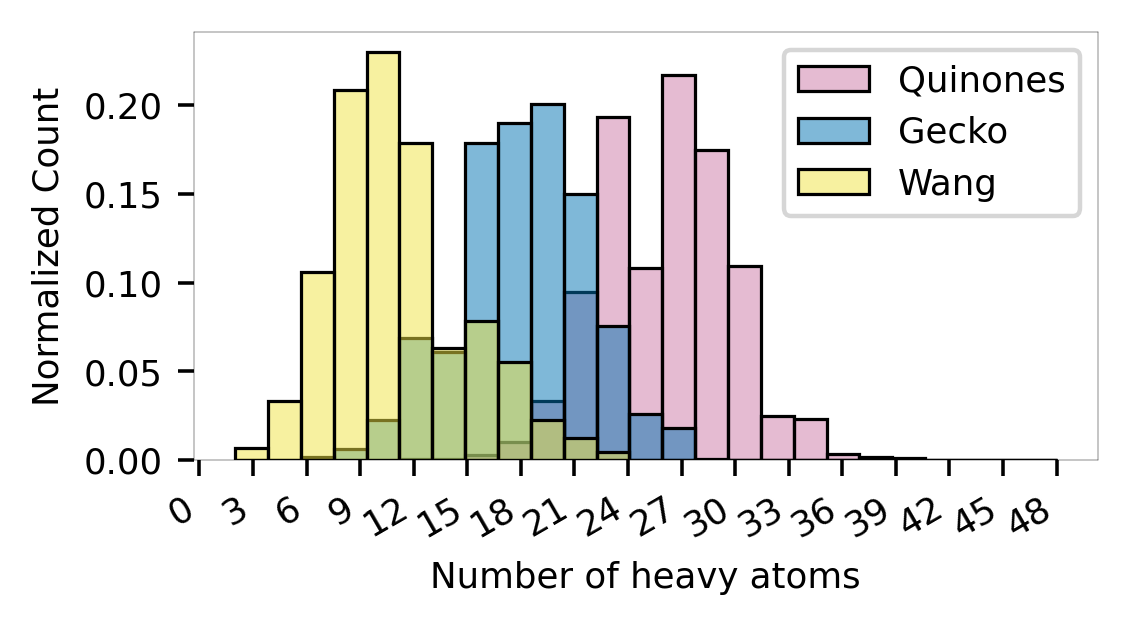

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Constants
nbins = 25  # Number of bins
colorblind_palette = ['#D55E00', '#E69F00', '#009E73', '#56B4E9', '#0072B2', '#CC79A7', '#F0E442']
colors = [colorblind_palette[6], colorblind_palette[4], colorblind_palette[5]]  # Colors for 'color_atm'
labels = ['Quinones', 'Gecko', 'Wang']  # Legend labels

# Plotting
plt.rc('font', size=8)
fig, ax1 = plt.subplots(figsize=(3.57, 2.0), dpi=320, constrained_layout=True)

# Plot histogram with normalized counts
sns.histplot(data=adist_pd, x='# heavy atoms', hue='label', bins=nbins, stat='probability', palette=colors, common_norm=False)

# Calculate and print normalized counts for each category
for label in labels:
    subset_data = adist_pd[adist_pd['label'] == label]
    counts, _ = np.histogram(subset_data['# heavy atoms'], bins=nbins)
    normalized_counts = counts / counts.sum()
    print(f"Sum of normalized counts for '{label}': {normalized_counts.sum()}")

ax1.set_xticks(np.arange(0, np.max(adist_pd['# heavy atoms']) + 1, np.round(np.max(adist_pd['# heavy atoms']) / 15)))
plt.legend(labels)
plt.ylabel('Normalized Count')
plt.xlabel('Number of heavy atoms')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(foldername + '/' + 'atmospheric_heavyAtoms_dist.png', bbox_inches='tight', dpi=320)
plt.show()


In [40]:
datasets = load_natm_datasets()
ar_list = []
adist_list = []
for label in datasets.keys(): 
    d=pd.read_csv(output_filepath+label+'.descr.csv', 
                  compression={'method':'gzip', 'compresslevel': 1,'mtime': 1}, 
                  low_memory=False)
    orig = d.copy(deep=True)
    a_types = arange_atomic_distribution(d).reset_index().rename({0:'number'}, axis='columns')
    d.columns = d.iloc[0]
    d.drop(0, inplace=True)
    a_r = arange_atomic_ratios(d, label)
    ar_list.append(a_r)  
    adist_list.append(arange_heavy_atoms(d, label))
    plot_number_of_heavy_atoms(d, label, foldername)
    
ar_pd = pd.concat(ar_list, axis=0)    
adist_pd = pd.concat(adist_list, axis=0)  

Plot area size (in inches):
Width: 0.8107590258325552
Height: 0.6514511677850627


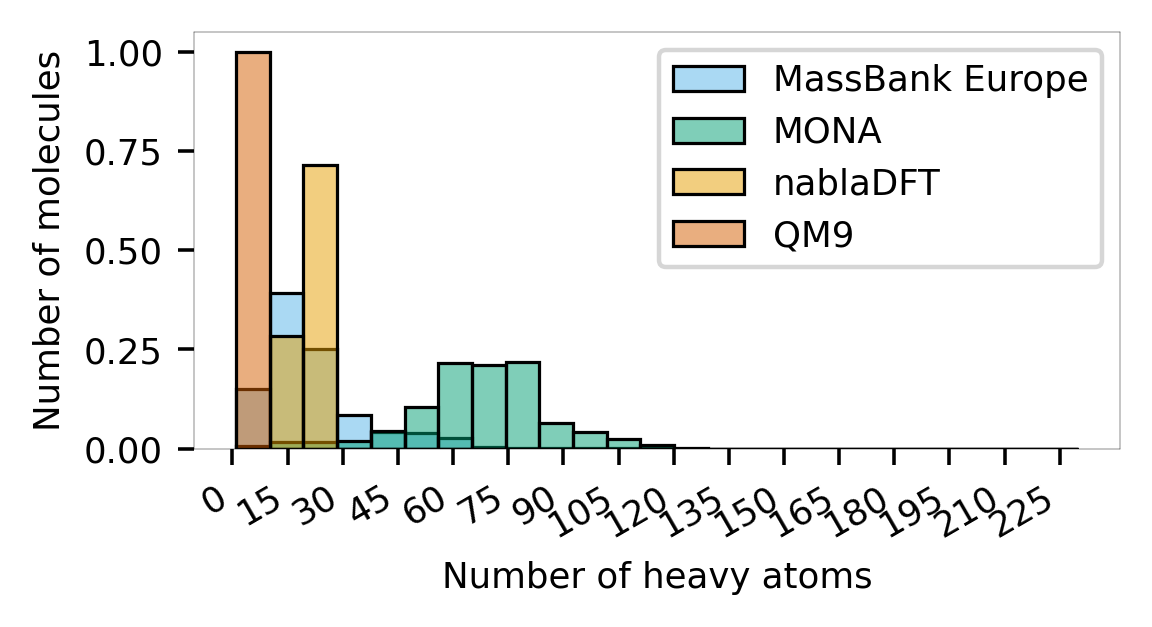

In [41]:
plt.rc('font', size=8)
fig, ax1 = plt.subplots(figsize=(3.57, 2.0), dpi=320, constrained_layout=True)
mycolors = []
# Set the palette
colorblind_palette = ['#D55E00', '#E69F00', '#009E73', '#56B4E9', '#0072B2', '#CC79A7', '#F0E442']
sns.set_palette(colorblind_palette)
colors = colorblind_palette

nbins = 200
bin_edges = np.linspace(0, 1, nbins + 1)
total = np.zeros(nbins)
color_atm = [colors[6], colors[4], colors[5]]
color_natm = [colors[0], colors[1],colors[2],  colors[3]]
sns.histplot(data=adist_pd, x='# heavy atoms', hue='label', bins=25, stat='probability', palette=color_natm, common_norm=False);
ax1.set_xticks(np.arange(0, np.max(adist_pd['# heavy atoms'])+1, np.round(np.max(adist_pd['# heavy atoms'])/15)))

plt.ylabel('Number of molecules')
plt.xlabel('Number of heavy atoms')
plt.legend(['MassBank Europe', 'MONA', 'nablaDFT', 'QM9'])

plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()

# Get the position of the subplot (bounding box)
bbox = ax1.get_position()

# Get the width and height of the bounding box in inches
plot_width_inches = bbox.width
plot_height_inches = bbox.height

# Display the size of the plot area
print("Plot area size (in inches):")
print("Width:", plot_width_inches)
print("Height:", plot_height_inches)

plt.savefig(foldername+'/'+'non-atmospheric_heavyAtoms_dist.png',
            bbox_inches='tight', dpi=320)

In [ ]:
adist_pd.groupby('label').mean()

In [ ]:
adist_pd.loc[adist_pd['label'] == 'mb_eu']['# heavy atoms'].mean()

# Plot atomic ratios

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Set the palette
colorblind_palette = ['#D55E00', '#E69F00', '#009E73', '#56B4E9', '#0072B2', '#CC79A7', '#F0E442']
sns.set_palette(colorblind_palette)
colors = colorblind_palette

def plot_datalist(datas, colors, title,legend):
    # Example usage
    df_list = []
    for key in datas.keys():
        print(key)
        stats = pd.read_csv('../data/output/'+key+'.descr.csv',
                            compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1},
                            dtype=str)
        stats = stats[[col for col in stats.columns if 'Atom ratios' in col]]
        headers = stats.iloc[0]
        stats  = pd.DataFrame(stats.values[1:],
                              columns=headers)[['H:C','N:C','O:C']].astype('float')
        df_list.append(stats)
        
        columns_list = ['O:C', 'H:C', 'N:C']  # List of column names
        markers_list = ['o', 's', '^','v','*','D','p','x']  # List of markers
        plot_average_with_error_bars(df_list, legend, columns_list, markers_list, colors)

def plot_average_with_error_bars(dataframes, labels, columns, markers, colors):
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(3.57, 2.0), dpi=320, constrained_layout=True)
    plt.rc('font', size=8)
    
    for i, dataframe in enumerate(dataframes):
        means = dataframe[columns].mean()
        std_devs = dataframe[columns].std()

        # Plot the means with error bars and specified marker
        ax.errorbar(x=means.index, y=means, yerr=std_devs, fmt=markers[i],
                    label=labels[i], color=colors[i], capsize=5, alpha=0.5,
                             markeredgecolor='black', markeredgewidth=0.7)
    # Add legend
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('../reports/figures/'+title+'.png',
                bbox_inches='tight')
    

    
atm_datasets={'Quinones':"tabor_nosulf.dump",
          'Wang':'wang_data.dump',
          'Gecko':'gecko_full.dump'}

atm = [ colors[5], colors[6], colors[4]]
title='atm_AR'
legend=['Quinones', 'Wang', 'Gecko']

plot_datalist(atm_datasets, atm, title,legend)
natm_datasets={'QM9':"qm9_data.dump",
          'nablaDFT':"nablaDFT.dump",
         'mb_eu':"mb_eu_cleaned.dump",
         'ExpMoNA':"allmona_cleaned.dump"}

natm = [colors[0], colors[1], colors[3], colors[2]]
title='natm_AR'
legend=['QM9','nablaDFT','MassBank Europe','MONA']
plot_datalist(natm_datasets, natm, title, legend)

# Functional groups

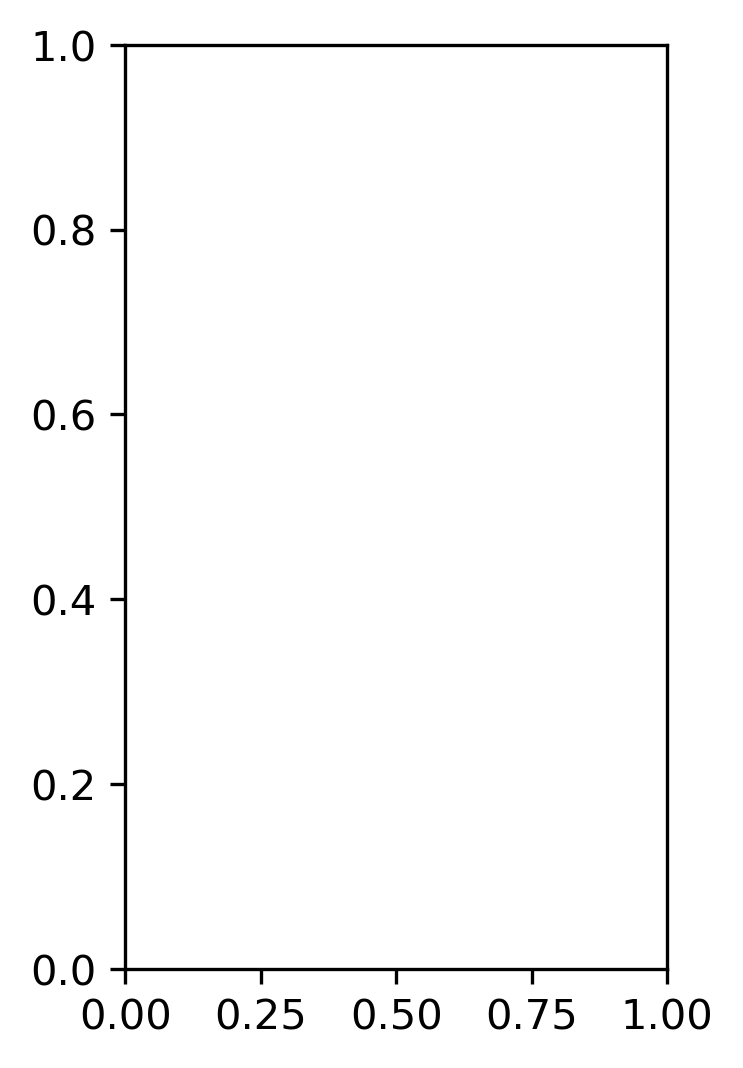

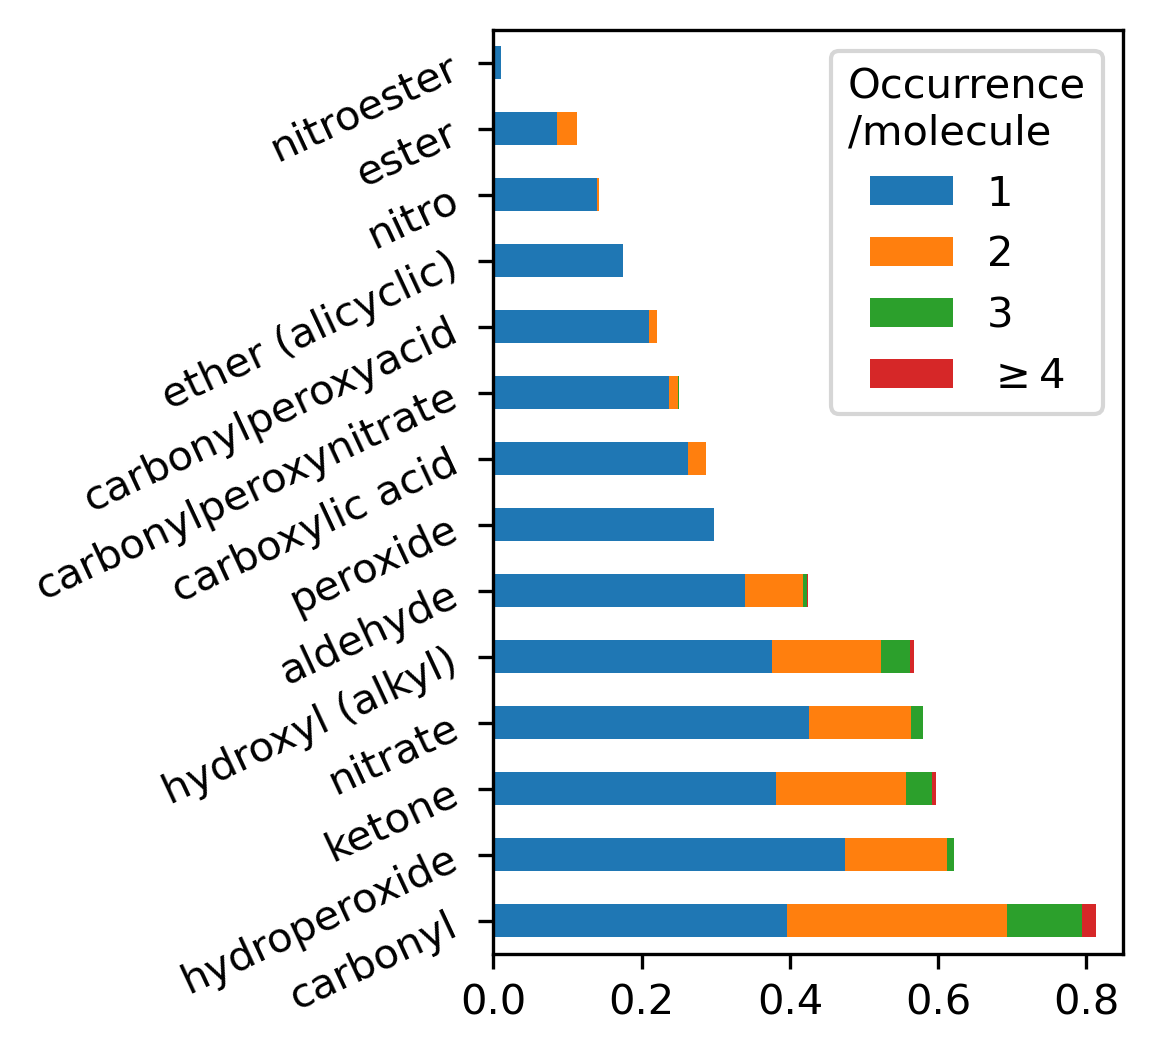

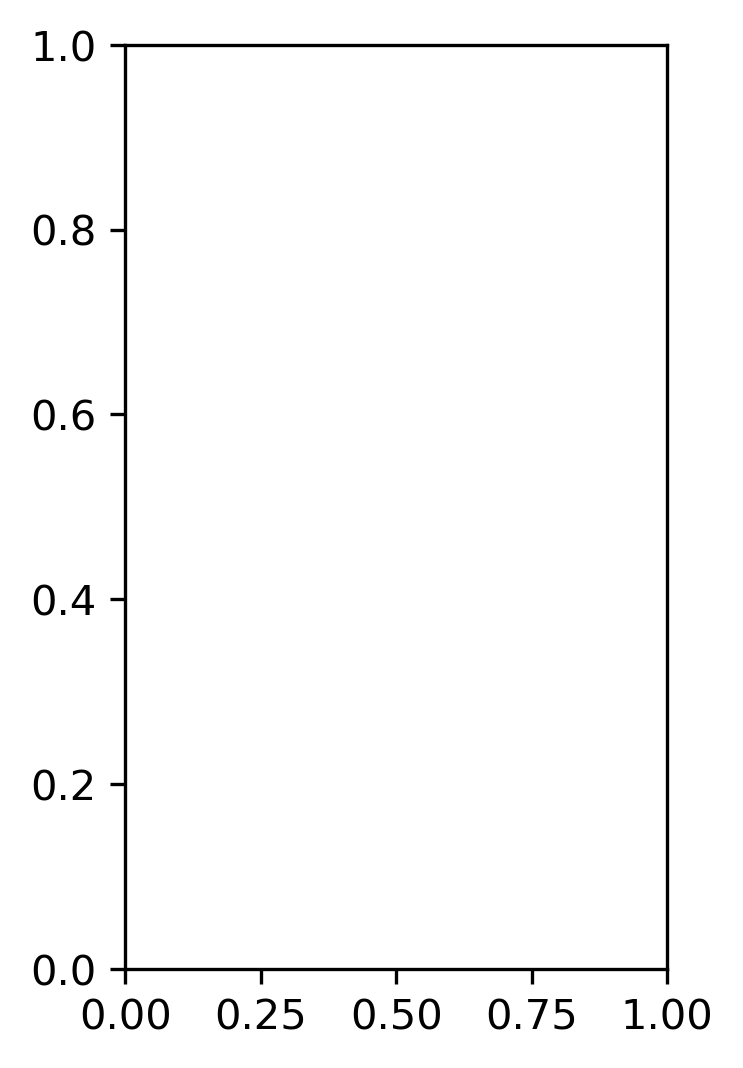

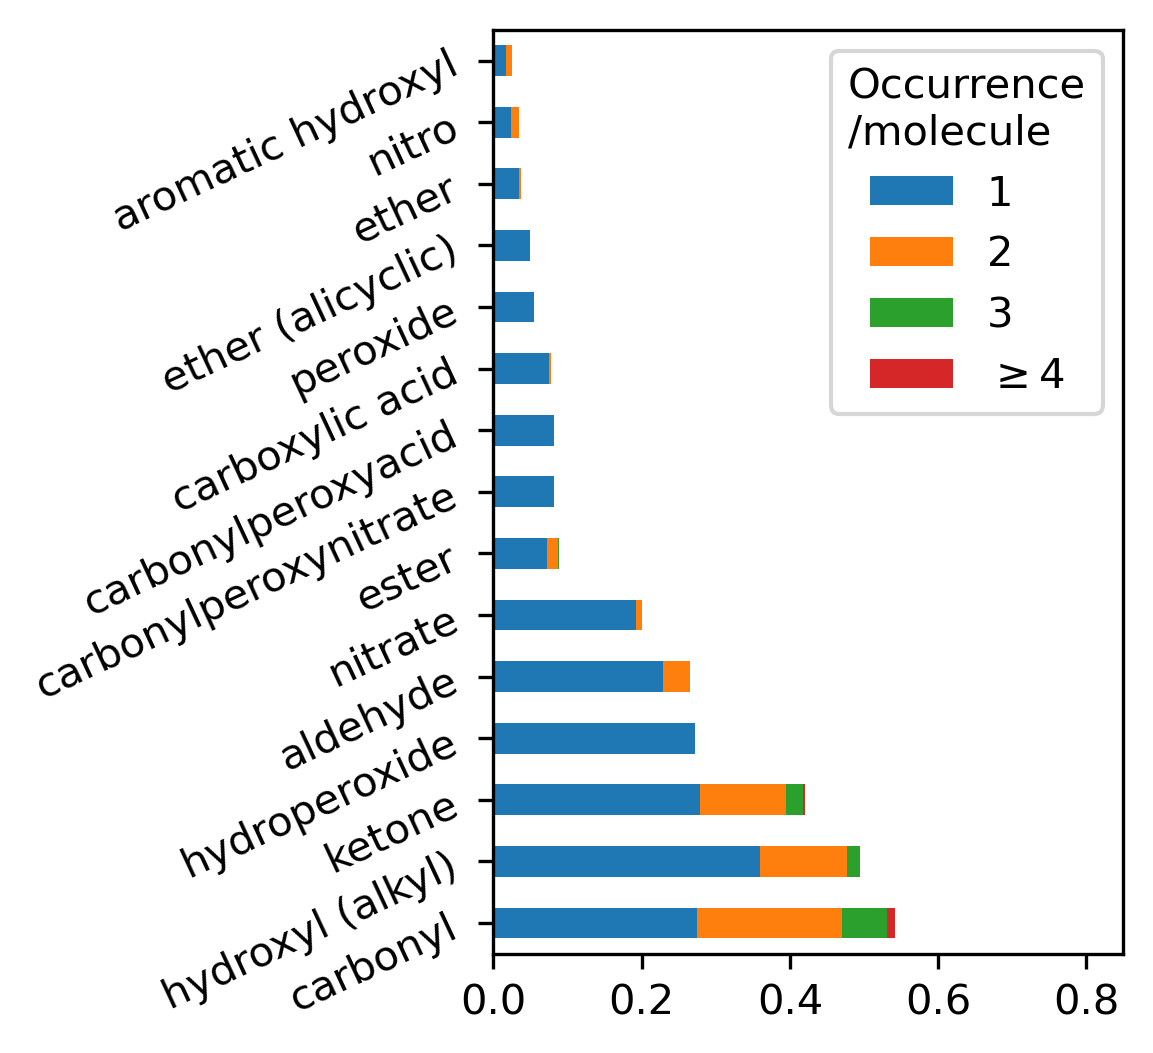

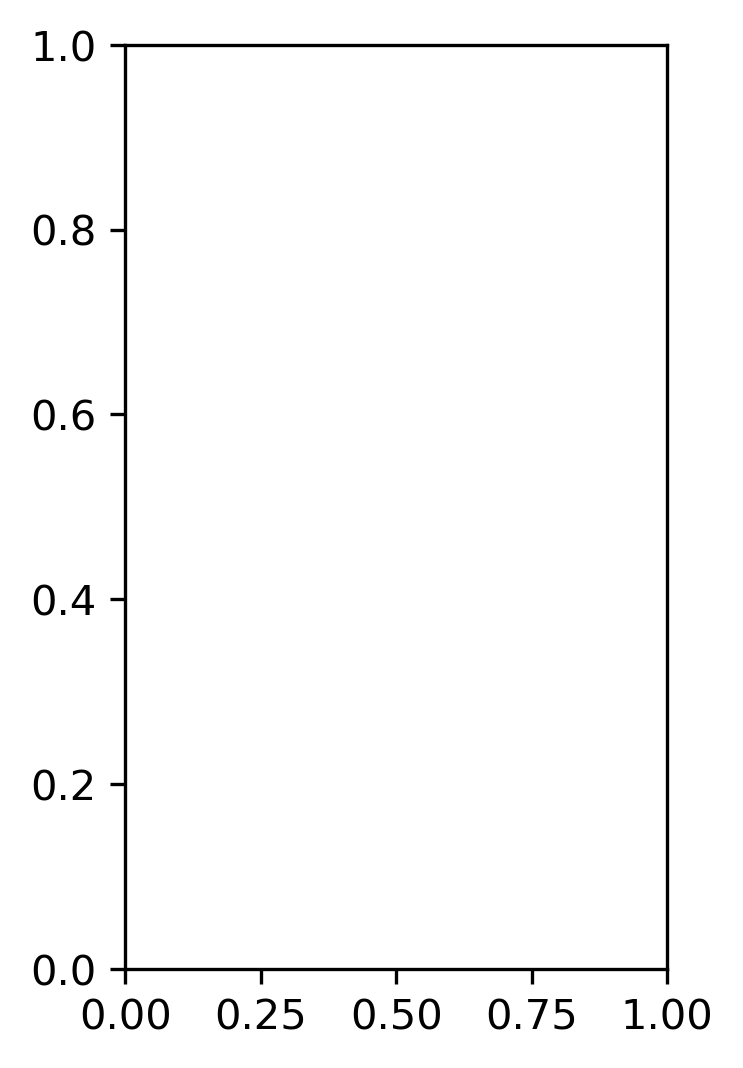

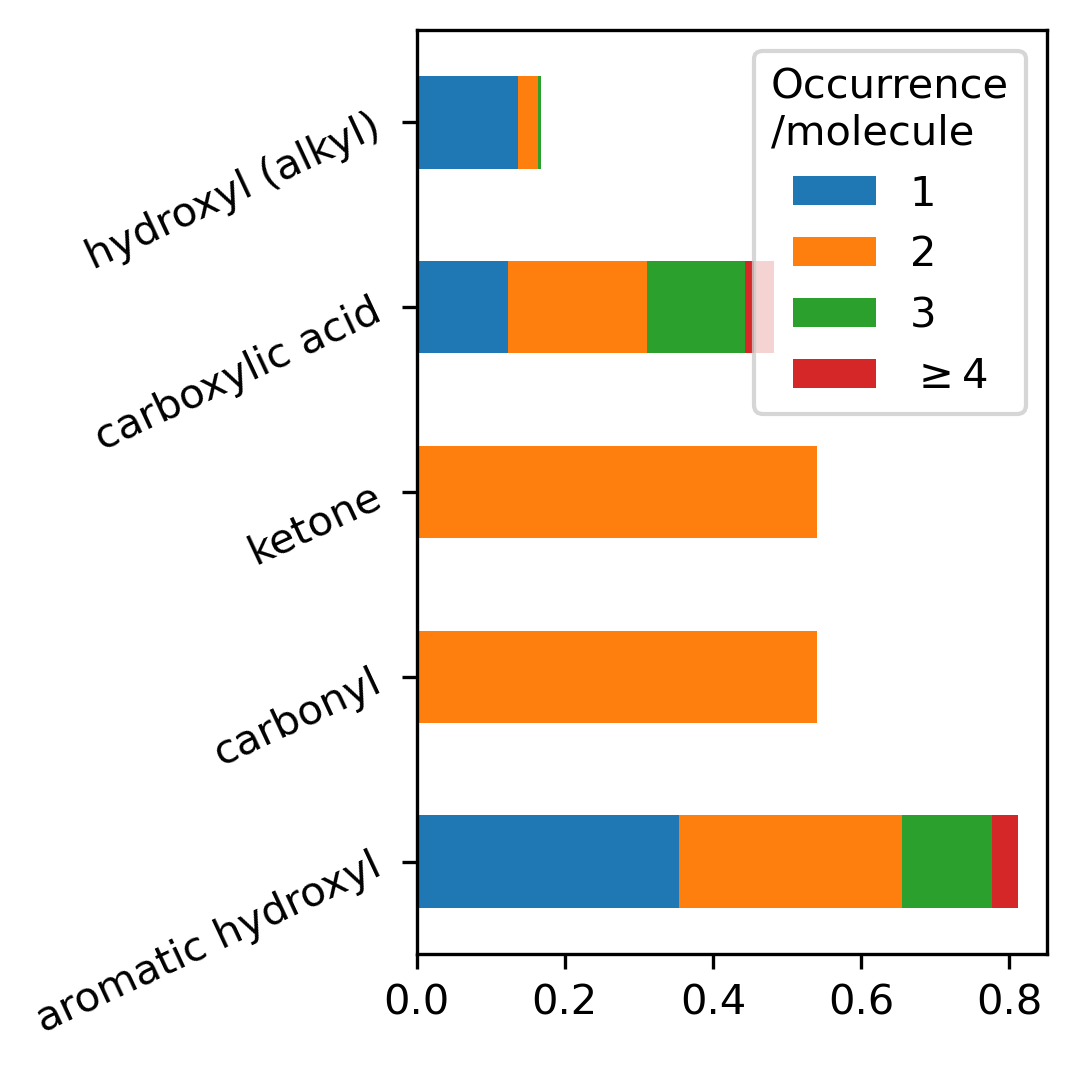

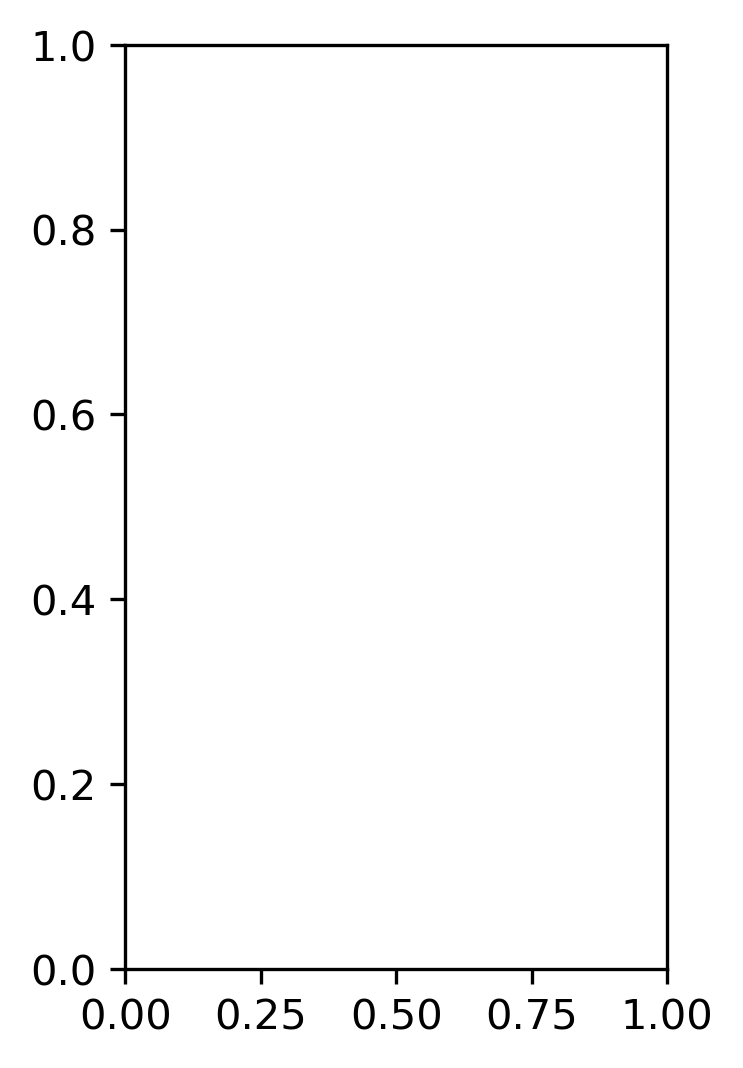

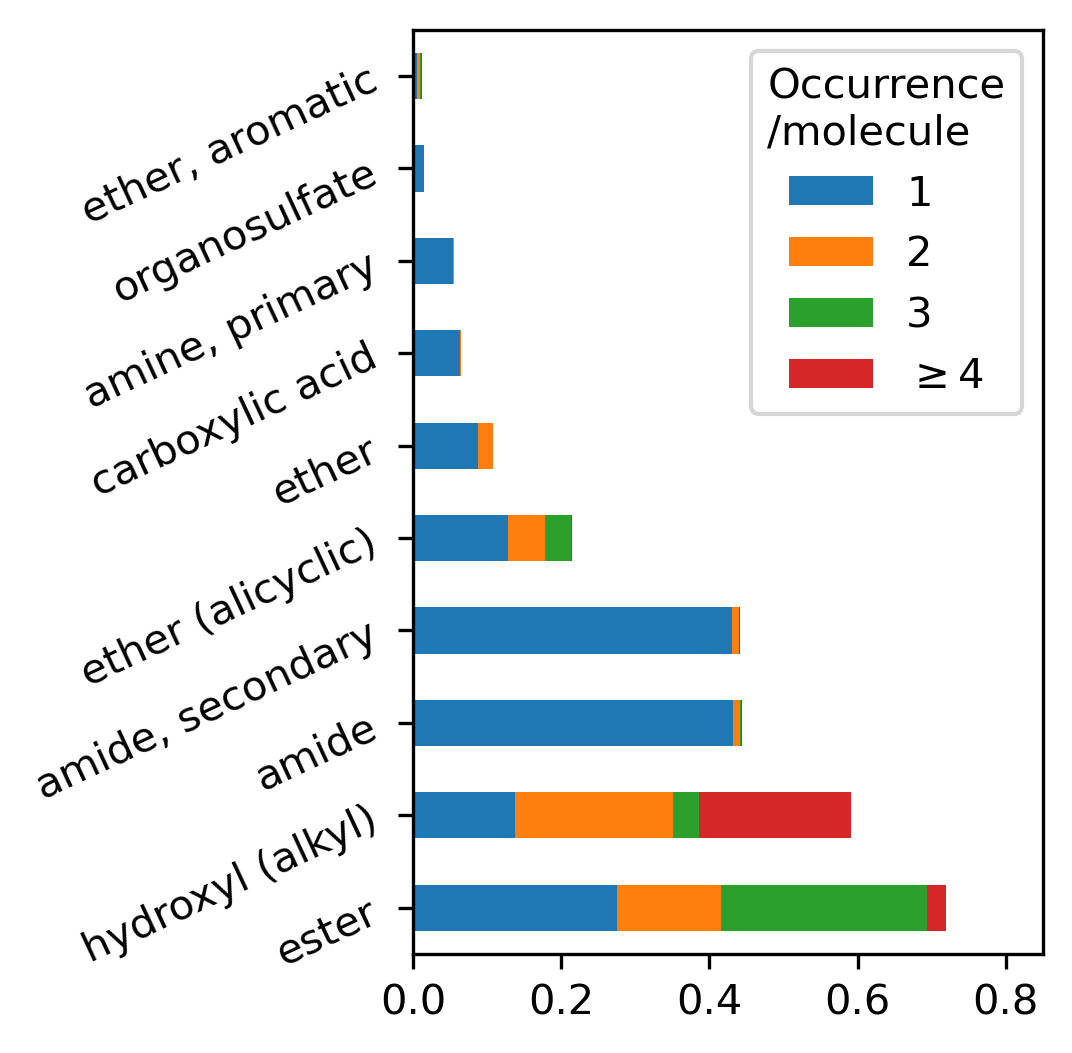

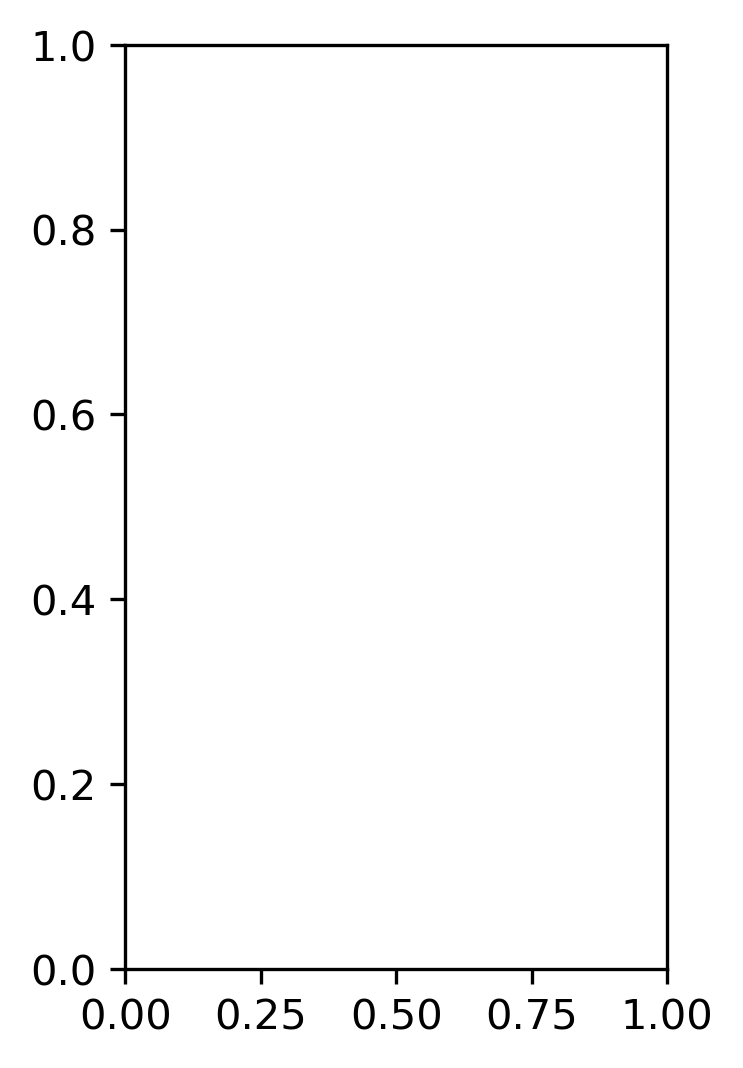

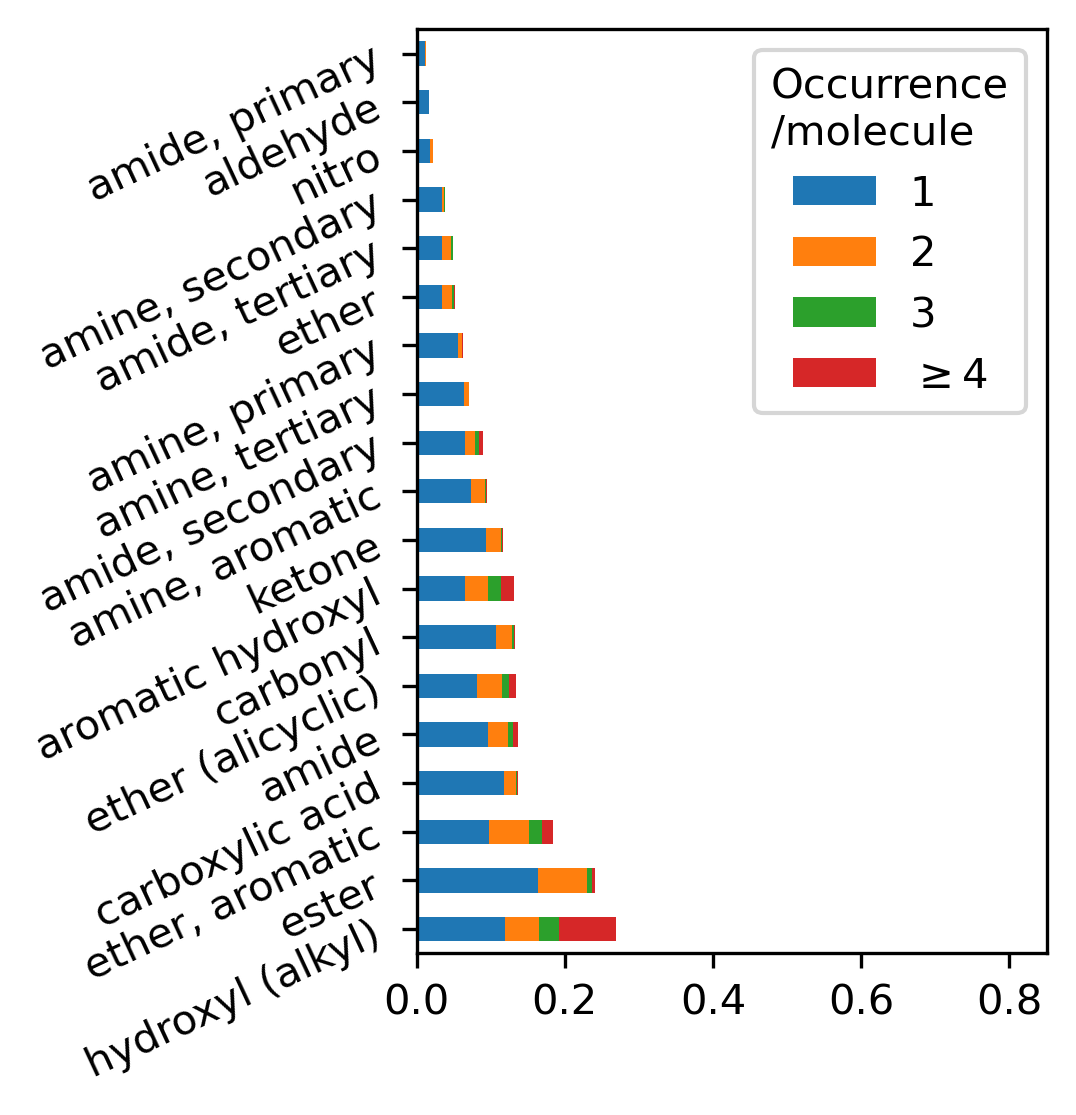

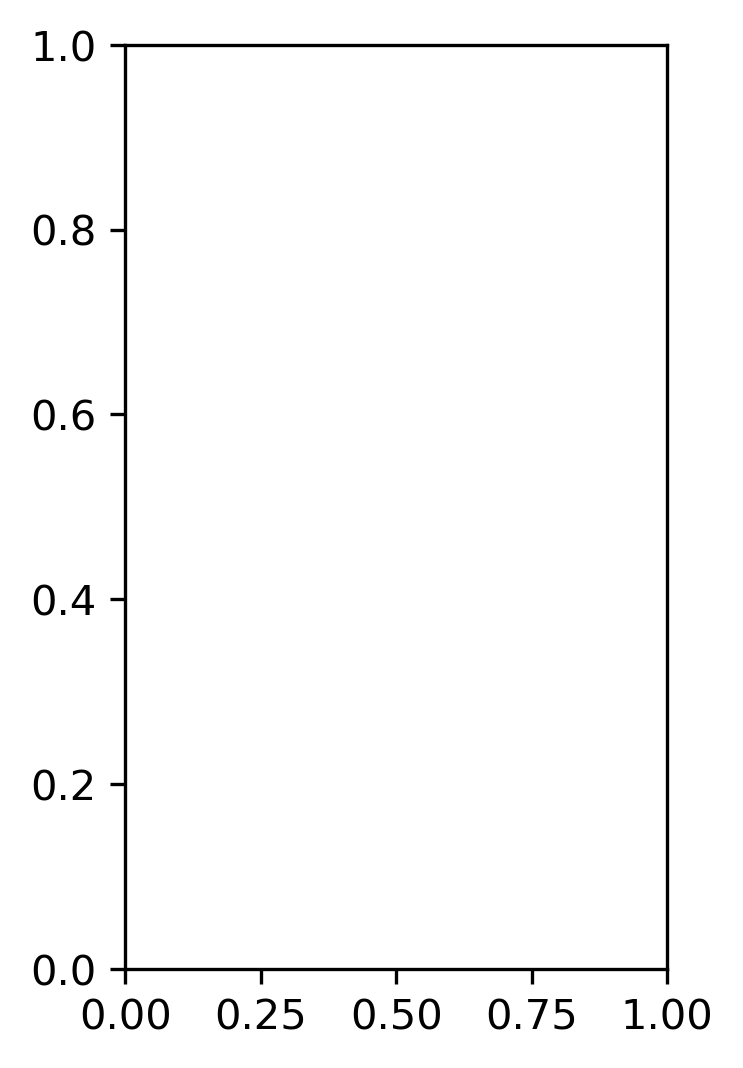

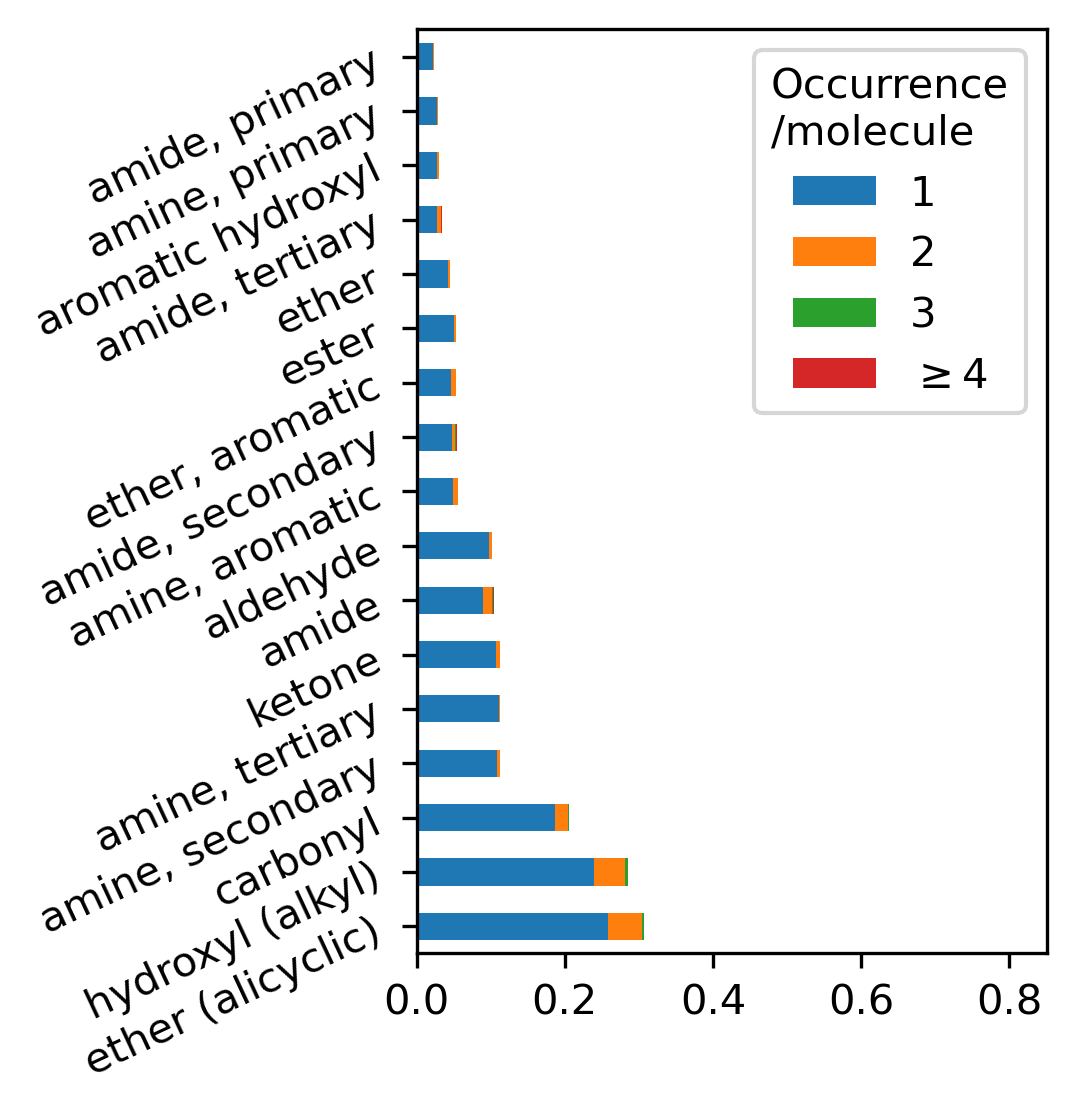

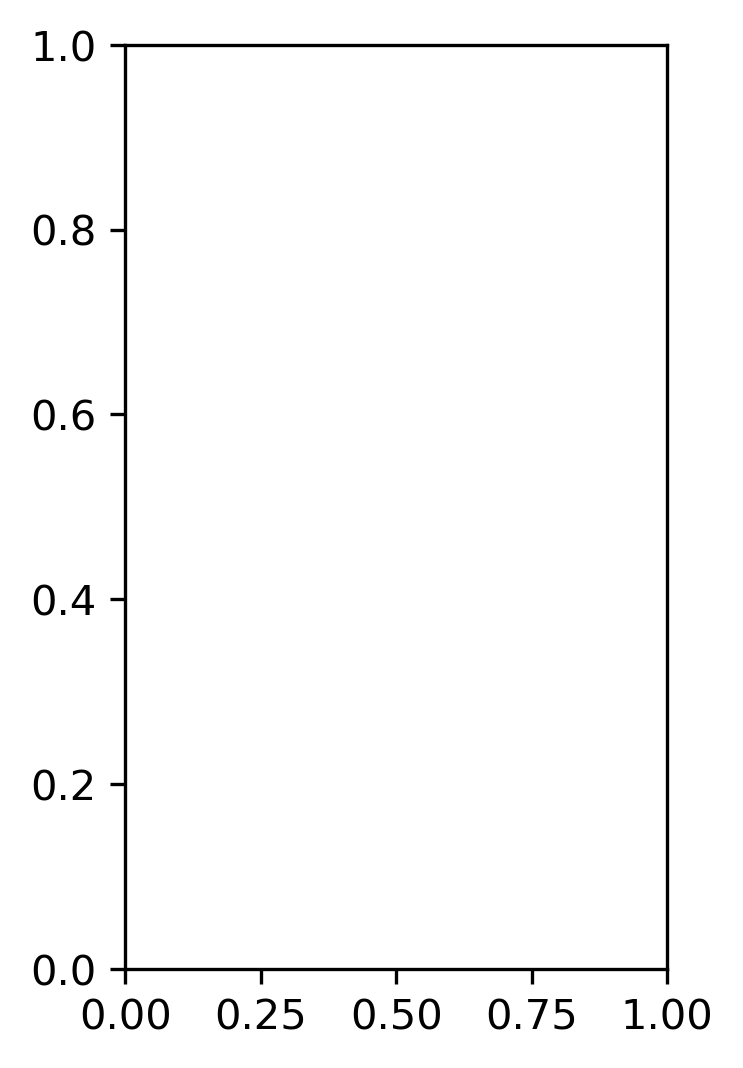

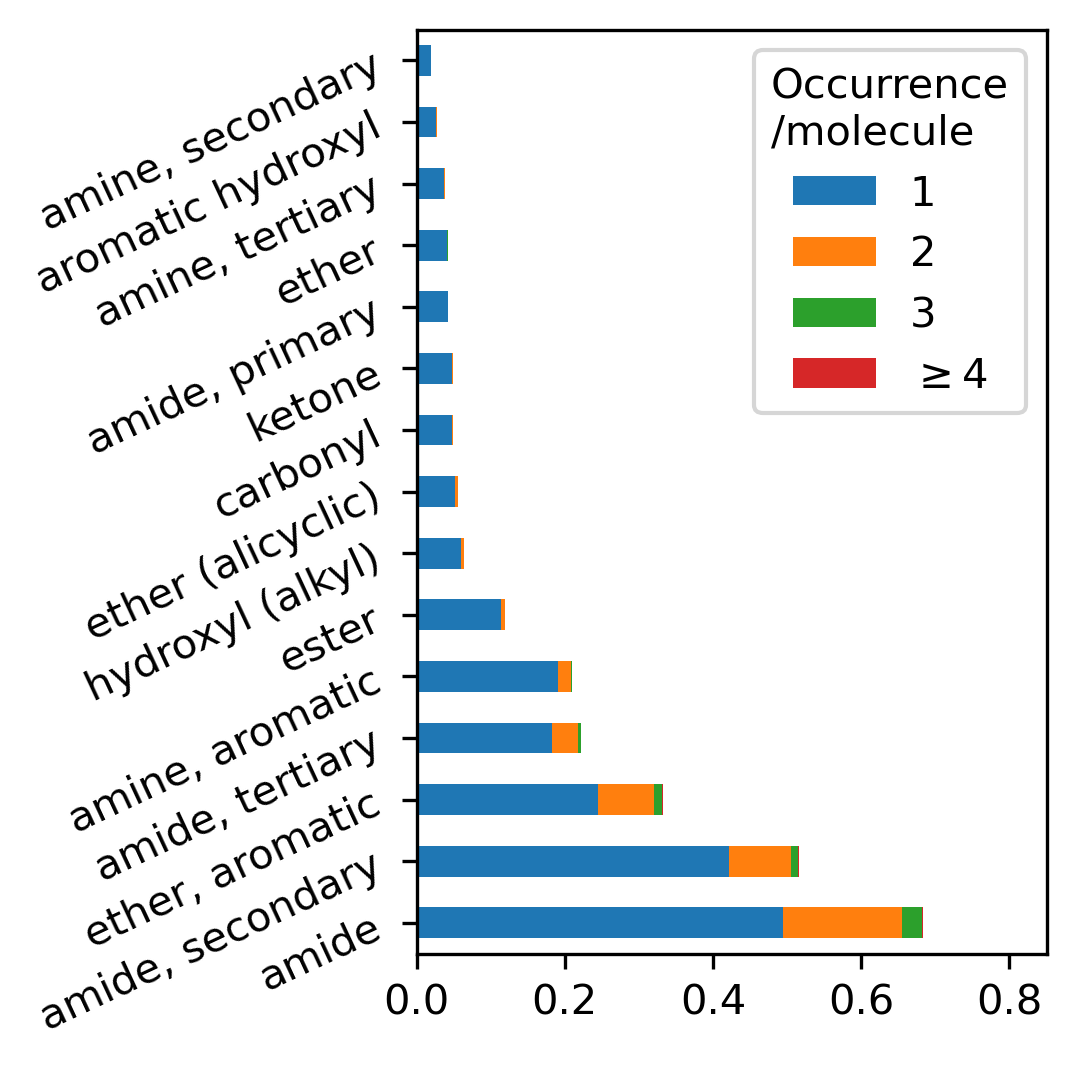

In [2]:
import joblib as jl 
import seaborn as sns
import pandas as pd
import sys, os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import click
import logging

fg_datasets={'Gecko':"../data/output/Gecko_SIMPOLgroups.csv",
             'Wang':"../data/output/Wang_SIMPOLgroups.csv",
         'Quinones':"../data/output/Quinones_SIMPOLgroups.csv",
         'ExpMoNA':"../data/output/ExpMoNA_SIMPOLgroups.csv",
         'Massbank, EU':"../data/output/mb_eu_SIMPOLgroups.csv",
             'QM9':"../data/output/QM9_SIMPOLgroups.csv",
            'nablaDFT':"../data/output/nablaDFT_SIMPOLgroups.csv"}
threshold=0.01
report_path = '../reports/figures/'
for key in fg_datasets:
	df = pd.read_csv(fg_datasets[key])
	df = pfg.process_data(df)
	df_c = pfg.count_values(df,threshold)
	pfg.plot_fun_group_count_bar(df_c, threshold, report_path, key)  